# Simple protein folding using quantum annealing
Implement the HP model after [Perdomo _et al._](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.78.012320)

In [159]:
using QuantumOptics
using PyPlot
using LinearAlgebra
using LaTeXStrings

## Defining the Hamiltonian

Because of the many degrees of freedom involved, protein folding is a complicated problem. The amino acids that make up the protein are linked by chemical bonds, but these can be at arbitrary angles, and so the state space is huge. Although it's a classical problem at heart, it's difficult to find the configuration that has the lowest energy. Following [Perdomo _et al._](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.78.012320) we'll explore how quantum annealing can potentially simplify things, by mapping the problem on a Hamiltonian, and slowly ramping into this from a transverse Ising model. Below we'll see why this works so well.

To keep things simple we'll need to make a few approximations. For one we'll assume the amino acids live on a two-dimensional lattice. This discretizes the degrees of freedom, but we'll still be able to get characteristic folding behavior out of it. We'll also assume there are only two types of amino acids: polar ones and hydrophobic ones (this is known as [the HP model](https://en.wikipedia.org/wiki/Hydrophobic-polar_protein_folding_model)). The hydrophobic ones like to avoid the water in the solution they're invariably part of, and so there's an energy reduction if we can get two or more to stick together. (It is possible to design models with more complicated interactions; for instance using the [Miyazawa-Jernigan matrix](https://onlinelibrary.wiley.com/doi/full/10.1002/prot.10239?casa_token=jxV3qZED8YMAAAAA%3ADQr0nz2QYj2PG0qaTfNSDDfT7Bvja9_8TpDoCpdulXb-jChZMcYEP16cupMto2S-QmYkLhzTbGNfWA).)

Finally, we'll only look at four proteins (the HPPH chain). This requires a $4\times 4$ lattice, since the chain will at most extend four sites along one axis. We can fix the two center proteins to the sites in the middle of the lattice because the problem is translationally invariant.

As [Perdomo _et al._](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.78.012320) point out, we need three terms in the Hamiltonian to accurately map the protein folding problem:
1. A term preventing double-occupancy of a single site,
2. A term guaranteeing the amino acids form a chain,
3. A term accounting for some amino acids being hydrophobic, encouraging them to stick together.

We describe the position of the amino acids by converting the $x$ and $y$ coordinates to binary numbers. Since there are four sites in each direction we need two binary digits per axis, so the position of each protein is described by four qubits. The position of the first protein is given by $q_4q_3q_2q_1$, where $0011$, for instance, corresponds to the bottom right corner of the lattice.

The full state of the system is described by the vector
$$
    \mathbf{q} = q_{16} q_{15} \cdots q_2 q_1,
$$
although - since the middle proteins have a fixed position - the string $q_{12}\cdots q_5$ is constant, so we have eight actual qubits left.

Let's first set up the basis:

In [163]:
N = 4           # Number of amino acids
D = 2           # Dimension of system

Nqubits = Int( (N-2)*D*log2(N) )  # We fix the two middle amino acids, so use N-2
basissize = 2^Nqubits

singlebasis = GenericBasis(2)
basis = tensor(repeat([singlebasis], Nqubits)...)
id = identityoperator(basis);

Define the operators $q_i$ acting on the $i$th qubit. We squeeze the string $10100110$ in between to describe the fixed positions of the middle two amino acids.

In [3]:
function get_q(i)
    id_array = repeat([identityoperator(singlebasis)], Nqubits)
    id_array[i] = diagonaloperator(singlebasis, complex([0.0, 1.0]))
    return tensor(id_array...)
end

qs = [get_q(i) for i ∈ 1:Nqubits]
q_insert = [identityoperator(basis) * q for q ∈ [1, 0, 1, 0, 0, 1, 1, 0]]
qs = [qs[1:4]..., q_insert..., qs[5:end]...];

Define the function that executes the `XNOR` operation on two qubits, and the function $f(i,k)$ that finds the particular qubit corresponding to the start of the bit string describing the coordinate on the axis $k$ for amino acid $i$. We also need the operator that gives us the square of the distance between two amino acids $i$ and $j$. (Cf. pp. 4-5 of [Perdomo _et al._](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.78.012320) for the definitions.)

In [4]:
xnor(i, j) = id - qs[i] - qs[j] + 2 * qs[i] * qs[j]
f(i, k) = Integer( D*(i - 1) * log2(N) + (k - 1) * log2(N) )
dsq(i, j) = sum([ sum([2^(r - 1) * ( qs[ f(j, k) + r ] - qs[ f(i, k) + r ] ) for r ∈ 1:2])^2 for k ∈ 1:2])

dsq (generic function with 1 method)

#### On-site term
Define the onsite term between two amino acids $i$ and $j$, and sum it up to obtain the full Hamiltonian term. This operator checks whether all of the qubits that describe the positions of two amino acids are the same, and if they are it results in an energy penalty.

In [5]:
H_onsite(i, j) = prod([xnor(f(i, k) + r, f(j, k) + r) for r ∈ 1:2 for k ∈ 1:2])
H_onsite_total = sum([H_onsite(i, j) for i ∈ 1:(N-1) for j ∈ (i+1):N]) - H_onsite(2, 3);

#### Primary structure term
Next we need a term that ensures the amino acids form a continuous chain on the lattice. We need the distance between two consecutive amino acids to equal 1, if it doesn't there's an energy penalty. Note that this term would encourage two amino acids to sit on the same site, for then the distance between them would be zero. This is offset by making the energy penalty of the on-site term larger than that of the primary structure term.

In [63]:
H_prim = -(N - 1) * id + sum([dsq(i, i + 1) for i ∈ 1:(N - 1)]);

#### Interaction term
For the hydrophobic proteins we need operators to check whether there's another hydrophobic to their left, right, top, or bottom. Obtaining these operators is quite involved; the producedure is described on pp. 5-7 of [Perdomo _et al._](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.78.012320).

In [64]:
xp(i, j) = ( (id - qs[ f(i, 1) + 1 ]) * qs[ f(j, 1) + 1 ] * xnor( f(j, 1) + 2, f(i, 1) + 2 )
    * prod( [xnor( f(i, 2) + s, f(j, 2) + s ) for s ∈ 1:2]) )
xm(i, j) = ( (id - qs[ f(i, 1) + 1 ]) * qs[ f(j, 1) + 1 ] * qs[ f(i, 1) + 2 ]
    * ( qs[ f(j, 1) + 2 ] + qs[ f(i, 1) + 2 ] - 2 * qs[ f(j, 1) + 2 ] * qs[ f(i, 1) + 2 ] )
    * prod( [xnor( f(i, 2) + s, f(j, 2) + s ) for s ∈ 1:2] ) )
yp(i, j) = ( (id - qs[ f(i, 2) + 1 ]) * qs[ f(j, 2) + 1 ] * xnor( f(j, 2) + 2, f(i, 2) + 2 )
    * prod( [xnor( f(i, 1) + s, f(j, 1) + s ) for s ∈ 1:2] ) )
ym(i, j) = ( (id - qs[ f(i, 2) + 1 ] ) * qs[ f(j, 2) + 1 ] * qs[ f(i, 2) + 2 ]
    * ( qs[ f(j, 2) + 2 ] + qs[ f(i, 2) + 2 ] - 2 * qs[ f(j, 2) + 2 ] * qs[ f(i, 2) + 2 ] )
    * prod( [xnor( f(i, 1) + s, f(j, 1) + s ) for s ∈ 1:2] ) )

ym (generic function with 1 method)

In the HPPH chain it's only the first and fourth protein that are hydrophobic. We give the Hamiltonian an energy reduction if these two are next to each other:

In [164]:
H_pairwise(i, j) = xp(i, j) + xm(i, j) + yp(i, j) + ym(i, j)
H_pairwise_total = -H_pairwise(1, 4) - H_pairwise(4, 1);

Now we put it all together. We ensure that the energy cost of double occupancy is larger than the energy gain we get from the primary structure term if the distance between neighbors is zero.

In [165]:
λ0 = N + 1
λ1 = N
Htot = λ0 * H_onsite_total + λ1 * H_prim + H_pairwise_total;

Let's draw some configurations.

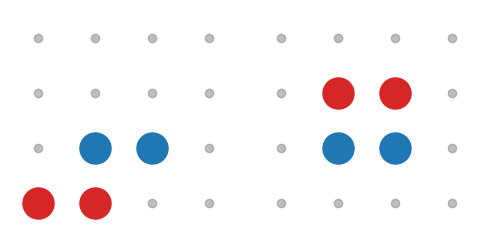

In [179]:
function to_coordinate(q)
    x = sum([2^(r - 1)*q[r] for r ∈ 1:2])
    y = sum([2^(r - 1)*q[r + 2] for r ∈ 1:2])
    return (x, y)
end

function draw_configuration(ax, q)
    xpts = ones(4)' .* [0:3;]
    ypts = [0:3;]' .* ones(4)
    ax.scatter(xpts, ypts, c = "gray", alpha = 0.5)
    ax.axis("off")
    
    aa_1 = to_coordinate(q[1:4])
    aa_2 = to_coordinate(q[5:end])
    
    mrk = 5e2
    ax.scatter([1], [1], [mrk], c = "C0")
    ax.scatter([2], [1], [mrk], c = "C0")
    ax.scatter(aa_1[1], aa_1[2], [mrk], c = "C3")
    ax.scatter(aa_2[1], aa_2[2], [mrk], c = "C3")

    
    ax.set_xlim([-0.5, 3.5])
    ax.set_ylim([-0.5, 3.5])
end

fig, ax = plt.subplots(1, 2, figsize = (5, 2.5))
draw_configuration(ax[1], [Integer(real(expect(qs[i], basisstate(basis, 2)))) for i ∈ [1:4; 13:16;]])
draw_configuration(ax[2], [Integer(real(expect(qs[i], basisstate(basis, 170)))) for i ∈ [1:4; 13:16;]])
fig.tight_layout()

## Annealing

It's actually quite straightforward to see what the minimum energy configuration is: put the first and fourth proteins next to each other while still satisfying the primary structure constraint (see above). But let's see if we can anneal our way into this.

The idea is to start with a state that's a superposition of all possible lattice configurations. A requirement is that this is a nondegenerate ground state of the initial Hamiltonian, which can then be slowly ramped into the Hamiltonian of the problem. The initial state we're after is
$$
    |\psi_0\rangle = \frac{1}{16} \left(|0\rangle + |1\rangle \right)^{\otimes 8},
$$
which maps onto the ground state of the transverse-field Ising Hamiltonian:
$$
    \mathcal{H}_\mathrm{Ising} = \sum_{i = 1}^8 \sigma_i^x.
$$
We then slowly ramp into the problem Hamiltonian, $\mathcal{H}_\mathrm{problem}$, over some time $\tau$:
$$
    \mathcal{H}(t) = (1-t/\tau)\mathcal{H}_\mathrm{Ising} + (t/\tau) \mathcal{H}_\mathrm{problem}.
$$
The ramp time needs to be sufficiently slow so that the system does not undergo any diabatic transitions out of the ground state as it traverses avoided crossings.

In [183]:
function get_qx(i)
    ops = repeat([identityoperator(singlebasis)], Nqubits)
    ops[i] = SparseOperator(singlebasis, complex([0.5 -0.5; -0.5 0.5]))
    return tensor(ops...)
end

qx_full = sum([get_qx(i) for i ∈ 1:Nqubits])
ψ0 = tensor(repeat([Ket(singlebasis, complex([1/sqrt(2), 1/sqrt(2)]))], Nqubits)...);

In [184]:
tau = 10
H(t, ψ) = (1-t/tau) * qx_full + t/tau * Htot

H (generic function with 1 method)

In [185]:
tspan = range(0, tau, length = 300)
ts, ψt = timeevolution.schroedinger_dynamic(tspan, ψ0, H);

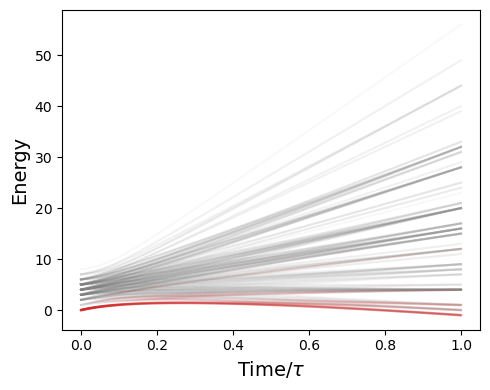

In [187]:
energies = zeros(2^Nqubits, length(tspan))

fig, ax = plt.subplots(figsize = (5, 4))
for (i, t) ∈ enumerate(tspan)
    en_instant, ϕs = eigenstates(dense(H(t, 0)), 2^Nqubits)
    energies[:, i] = en_instant
    coeffs = abs.([dagger(ϕ) * ψt[i] for ϕ ∈ ϕs]).^2
    ax.scatter(t/tau * ones(length(en_instant)), en_instant, s = 1, color = "C3", alpha = coeffs)
end

for i ∈ 1:2^Nqubits
    ax.plot(tspan/tau, energies[i, :], c = "gray", alpha = 0.05)
end

ax.set_xlabel(L"Time/$\tau$", fontsize = 14)
ax.set_ylabel("Energy", fontsize = 14)
fig.tight_layout()